In [1]:
!pip install xgboost
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


* **This dataset provides essential information about loan applicants and their characteristics.**
* **Assessing credit risk is crucial for lenders and financial institutions.**

**Column Descriptions:**

*     **ID**: Unique identifier for each loan applicant.

*     **Age**: Age of the loan applicant.

*    **Income**: Income of the loan applicant.

*    **Home**: Home ownership status (Own, Mortgage, Rent).

*    **Emp_Length**: Employment length in years.

*    **Intent**: Purpose of the loan (e.g., education, home improvement).

*    **Amount**: Loan amount applied for.

*    **Rate**: Interest rate on the loan.

*    **Status**: Loan approval status (Fully Paid, Charged Off, Current).

*    **Percent_Income**: Loan amount as a percentage of income.

*    **Default**: Whether the applicant has defaulted on a loan previously (Yes, No).

*    **Cred_Length**: Length of the applicant's credit history.Explore this dataset, preprocess the data as needed, and develop machine learning models, especially using Random Forest, to predict loan default. Your insights and solutions could contribute to better credit risk assessment methods and potentially help lenders make more informed decisions.

 **The EDA for this Dataset is in another notebook **

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder,MinMaxScaler

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split,GridSearchCV
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

In [3]:
df = pd.read_csv("credit_risk.csv")
df.head()

,Id,Age,Income,Home,Emp_length,Intent,Amount,Rate,Status,Percent_income,Default,Cred_length
0,0,22,59000,RENT,123.0,PERSONAL,35000,16.02,1,0.59,Y,3
1,1,21,9600,OWN,5.0,EDUCATION,1000,11.14,0,0.10,N,2
2,2,25,9600,MORTGAGE,1.0,MEDICAL,5500,12.87,1,0.57,N,3
3,3,23,65500,RENT,4.0,MEDICAL,35000,15.23,1,0.53,N,2
4,4,24,54400,RENT,8.0,MEDICAL,35000,14.27,1,0.55,Y,4


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Id              32581 non-null  int64  
 1   Age             32581 non-null  int64  
 2   Income          32581 non-null  int64  
 3   Home            32581 non-null  object 
 4   Emp_length      31686 non-null  float64
 5   Intent          32581 non-null  object 
 6   Amount          32581 non-null  int64  
 7   Rate            29465 non-null  float64
 8   Status          32581 non-null  int64  
 9   Percent_income  32581 non-null  float64
 10  Default         32581 non-null  object 
 11  Cred_length     32581 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 3.0+ MB


In [5]:
df.describe()

,Id,Age,Income,Emp_length,Amount,Rate,Status,Percent_income,Cred_length
count,32581.000000,32581.000000,3.258100e+04,31686.000000,32581.000000,29465.000000,32581.000000,32581.000000,32581.000000
mean,16290.006139,27.734600,6.607485e+04,4.789686,9589.371106,11.011695,0.218164,0.170203,5.804211
std,9405.479594,6.348078,6.198312e+04,4.142630,6322.086646,3.240459,0.413006,0.106782,4.055001
min,0.000000,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,8145.000000,23.000000,3.850000e+04,2.000000,5000.000000,7.900000,0.000000,0.090000,3.000000
50%,16290.000000,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,24435.000000,30.000000,7.920000e+04,7.000000,12200.000000,13.470000,0.000000,0.230000,8.000000
max,32780.000000,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


In [6]:
df.isnull().sum()

Id                   0
Age                  0
Income               0
Home                 0
Emp_length         895
Intent               0
Amount               0
Rate              3116
Status               0
Percent_income       0
Default              0
Cred_length          0
dtype: int64

****

In [7]:
df.drop(columns=["Id"],axis=1, inplace = True)

In [8]:
#Dropping duplicate values 
df.drop_duplicates(inplace=True)
df = df.reset_index(drop=True)#Resetting the index to make it continuous

In [9]:
max_ages = (df.Age > 99) | (df.Emp_length > 90)
max_ages = df[max_ages]
print(f"Total rows:{len(max_ages)}")
max_ages

Total rows:7


,Age,Income,Home,Emp_length,Intent,Amount,Rate,Status,Percent_income,Default,Cred_length
0,22,59000,RENT,123.0,PERSONAL,35000,16.02,1,0.59,Y,3
81,144,250000,RENT,4.0,VENTURE,4800,13.57,0,0.02,N,3
183,144,200000,MORTGAGE,4.0,EDUCATION,6000,11.86,0,0.03,N,2
210,21,192000,MORTGAGE,123.0,VENTURE,20000,6.54,0,0.10,N,4
575,123,80004,RENT,2.0,EDUCATION,20400,10.25,0,0.25,N,3
747,123,78000,RENT,7.0,VENTURE,20000,NaN,0,0.26,N,4
32132,144,6000000,MORTGAGE,12.0,PERSONAL,5000,12.73,0,0.00,N,25


In [10]:
rows_to_drop = max_ages.index
df.drop(rows_to_drop, inplace = True)
df = df.reset_index(drop=True)
df.shape

(32409, 11)

****

# **Splitting Dataset**

In [11]:
X = df.drop(columns=["Status"])
Y = df["Status"]

In [12]:
X_train,X_val,y_train,y_val = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train.shape,y_train.shape,X_val.shape,y_val.shape

((25927, 10), (25927,), (6482, 10), (6482,))

In [13]:
num_cols = X_train.select_dtypes(include=["int64","float64"]).columns
catg_cols = X_train.select_dtypes(include=["object"]).columns

****

# **Creating Pipelines**

In [14]:
# Imputing missing values
numerical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # Handle missing values with mean imputation
    ('scaler', MinMaxScaler())                  # Feature scaling
])

# Transforming Categorical Features
categorical_transformer = Pipeline([
    ('onehot',  OneHotEncoder(handle_unknown='ignore', drop='first'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, num_cols),
        ('cat', categorical_transformer, catg_cols)
])

# XGBoostClassifier
xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('xgb', XGBClassifier())
])

# RandomForestClassifier
rfc_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('rf', RandomForestClassifier(random_state=42))
])

****

# **GridSearchCV**

In [15]:
# Testing different parameters for Gradient Boosting
param_grid  = {
    'xgb__learning_rate': [0.07,0.1,0.15],  # Learning rate
    'xgb__n_estimators': [300,700,1000],    # Number of estimators (trees)
    'xgb__reg_alpha': [0.05,0.1,1.0]        # L1 Regularization(Lasso)
}

**Here we have not used L2 Regularization(Ridge) as there isn't much corelation between features in the dataset. This gives better results than Elastic Net.**

In [16]:
grid_cv = GridSearchCV(xgb_pipeline, param_grid, scoring="recall", cv=5)

**Here i have tried "Accuracy' as the scoring method as well, it has more or less the same results when it comes to accuracy.**

In [17]:
grid_cv.fit(X_train, y_train)

,estimator,"Pipeline(step...=None, ...))])"
,param_grid,"{'xgb__learning_rate': [0.07, 0.1, ...], 'xgb__n_estimators': [300, 700, ...], 'xgb__reg_alpha': [0.05, 0.1, ...]}"
,scoring,'recall'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('num', ...), ('cat', ...)]"


In [18]:
best_params = grid_cv.best_params_
print("Best parameters for XGBClassifier: ",best_params) 

Best parameters for XGBClassifier:  {'xgb__learning_rate': 0.15, 'xgb__n_estimators': 1000, 'xgb__reg_alpha': 0.05}


****

In [19]:
# XGBoostClassifier
best_xgbc_pipeline = grid_cv.best_estimator_
best_xgbc_pipeline

,steps,"[('preprocessor', ...), ('xgb', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [20]:
# RandomForestClassifier
rfc_pipeline.fit(X_train,y_train)

,steps,"[('preprocessor', ...), ('rf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [21]:
def pred_eval(model,pred_set,target): 
    
    model_pred = model.predict(pred_set)
    
    conf_matrix = confusion_matrix(target,model_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()
    
    accuracy = accuracy_score(target,model_pred)
    classification_rep = classification_report(target,model_pred)
    print("Accuracy:", accuracy)
    print("Classification Report:\n", classification_rep)        

****

# **RandomForestClassifier**

Performance On Training Set :




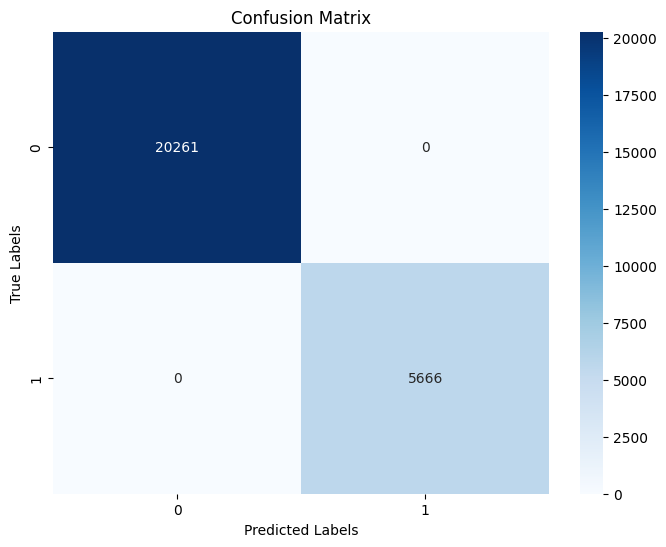

Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     20261
           1       1.00      1.00      1.00      5666

    accuracy                           1.00     25927
   macro avg       1.00      1.00      1.00     25927
weighted avg       1.00      1.00      1.00     25927



In [22]:
print("Performance On Training Set :\n\n")
pred_eval(rfc_pipeline,X_train,y_train)

Performance On Testing Set :




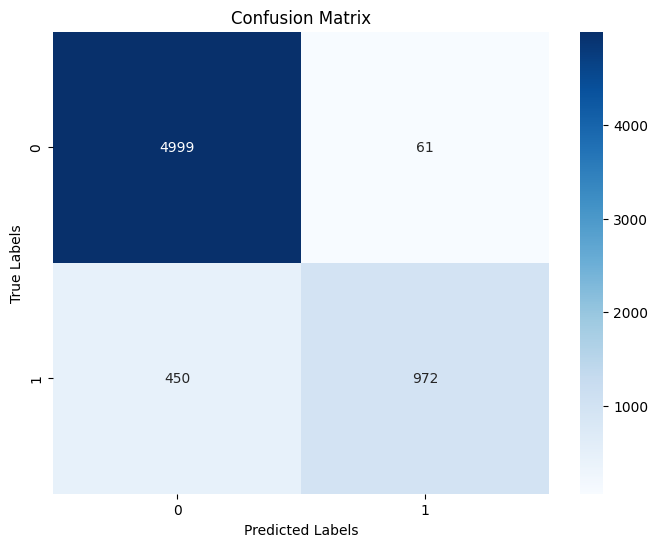

Accuracy: 0.9211663066954644
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.99      0.95      5060
           1       0.94      0.68      0.79      1422

    accuracy                           0.92      6482
   macro avg       0.93      0.84      0.87      6482
weighted avg       0.92      0.92      0.92      6482



In [23]:
print("Performance On Testing Set :\n\n")
pred_eval(rfc_pipeline,X_val,y_val)

# **XGBoost Classifier**

Performance On Training Set :




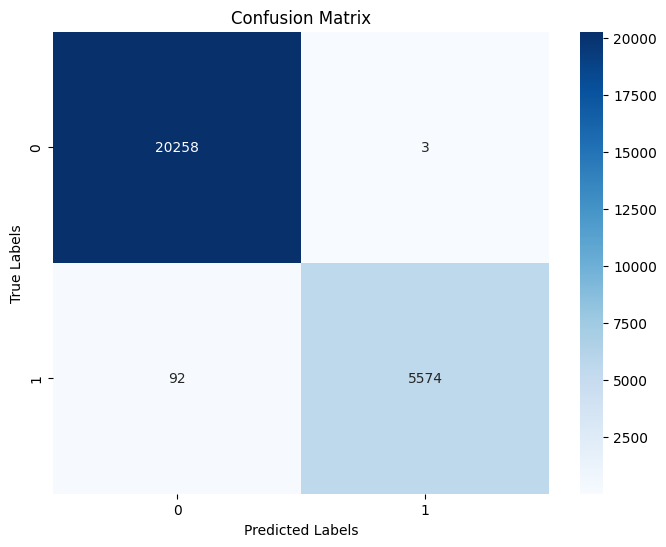

Accuracy: 0.9963358660855479
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     20261
           1       1.00      0.98      0.99      5666

    accuracy                           1.00     25927
   macro avg       1.00      0.99      0.99     25927
weighted avg       1.00      1.00      1.00     25927



In [24]:
print("Performance On Training Set :\n\n")
pred_eval(best_xgbc_pipeline,X_train,y_train)

Performance On Testing Set :




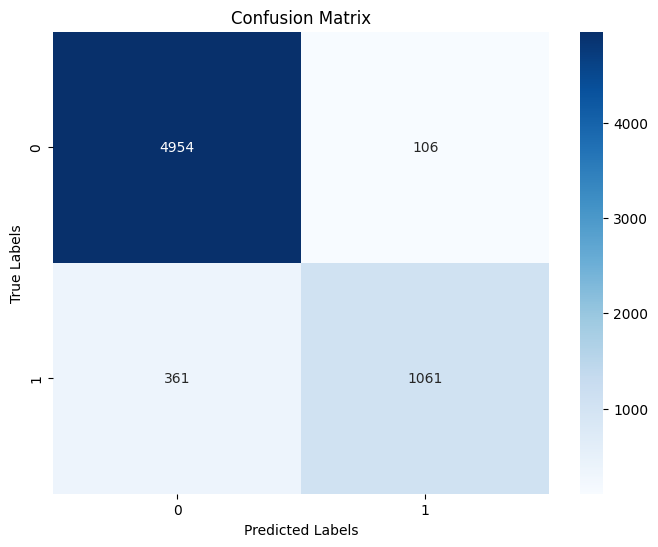

Accuracy: 0.9279543350817648
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.98      0.95      5060
           1       0.91      0.75      0.82      1422

    accuracy                           0.93      6482
   macro avg       0.92      0.86      0.89      6482
weighted avg       0.93      0.93      0.93      6482



In [25]:
print("Performance On Testing Set :\n\n")
pred_eval(best_xgbc_pipeline,X_val,y_val)

* **XGB has performed slightly better than RandomForest.**
* **RandomForest has an Accuracy of 1 on training set, but XGB has has generalized well on the training set.**
* **XGB has performed better on Recall score with 0.76 whereas RandomForest is at 0.68 almost 8% better, this indicates the model predicted more True Positives for 1 and thereby decreased False Negatives.**